In [7]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from data_cleaning import clean
import warnings
warnings.filterwarnings('ignore', message="Non-invertible starting MA parameters found")

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

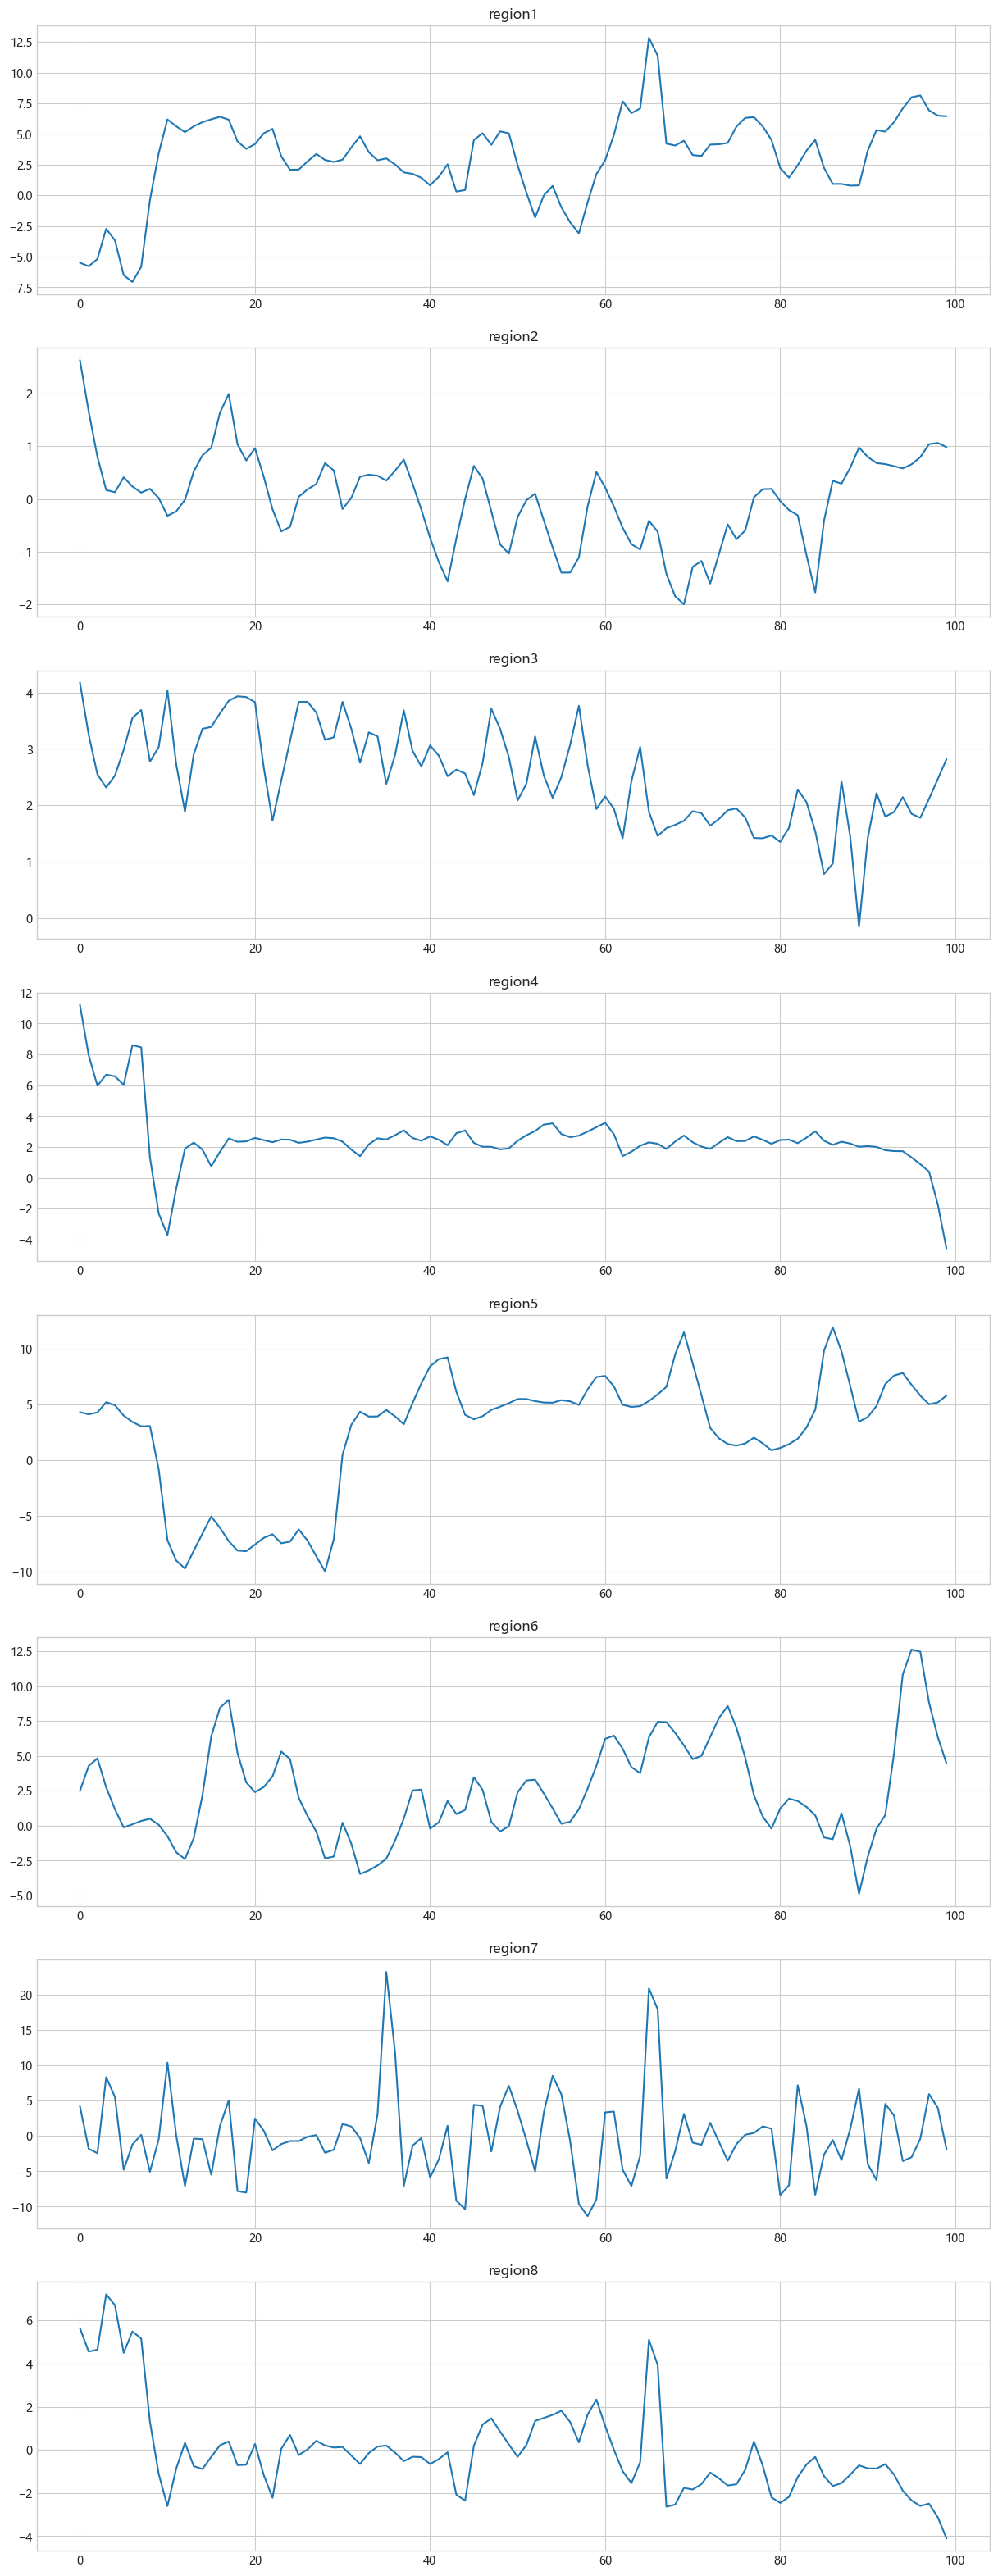

In [8]:
data = pd.read_excel('数据文件.xls')

# 数据清洗
data = clean(data)

# 数据可视化
fig ,ax = plt.subplots(8, 1, figsize=(15, 40))
for i in range(1, 9):
    ax[i-1].plot(data.iloc[:, i])
    ax[i-1].set_title('region%d' % i)

# plt.savefig('图片\原始数据图.png')

In [9]:
index = ['ADF统计值', 'p值', '临界值(1%)', '临界值(5%)', '临界值(10%)']
df_0 = pd.DataFrame(index=index, columns=['Region%d' % i for i in range(1, 9)])
df_1 = pd.DataFrame(index=index, columns=['Region%d' % i for i in range(1, 9)])

# ADF检验
for i in range(1, 9):
    ts = data.iloc[:, i]

    # ADF检验数据
    # 没有差分的DataFrame
    result = adfuller(ts)
    df_0['Region%d' % i] = [result[0], result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']]

    # 进行差分的DataFrame
    ts = ts.diff().dropna()
    result = adfuller(ts)
    df_1['Region%d' % i] = [result[0], result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']]

print('原始数据的ADF检验结果：')
display(df_0)
print('一阶差分后的ADF检验结果：')
display(df_1)

原始数据的ADF检验结果：


,Region1,Region2,Region3,Region4,Region5,Region6,Region7,Region8
ADF统计值,-4.346335,-1.062038,-0.906856,2.140717,-1.894497,-2.602540,-4.942222,-3.326332
p值,0.000369,0.729971,0.785706,0.998830,0.334654,0.092474,0.000029,0.013742
临界值(1%),-3.501912,-3.506944,-3.504343,-3.506944,-3.499637,-3.506944,-3.505190,-3.501137
临界值(5%),-2.892815,-2.894990,-2.893866,-2.894990,-2.891831,-2.894990,-2.894232,-2.892480
临界值(10%),-2.583454,-2.584615,-2.584015,-2.584615,-2.582928,-2.584615,-2.584210,-2.583275


一阶差分后的ADF检验结果：


,Region1,Region2,Region3,Region4,Region5,Region6,Region7,Region8
ADF统计值,-5.568501,-4.153298,-6.415095e+00,-3.802654,-6.430970e+00,-3.398769,-5.299476,-3.516083
p值,0.000001,0.000790,1.849679e-08,0.002880,1.697811e-08,0.011001,0.000005,0.007584
临界值(1%),-3.501137,-3.508783,-3.504343e+00,-3.505190,-3.500379e+00,-3.506944,-3.507853,-3.508783
临界值(5%),-2.892480,-2.895784,-2.893866e+00,-2.894232,-2.892152e+00,-2.894990,-2.895382,-2.895784
临界值(10%),-2.583275,-2.585038,-2.584015e+00,-2.584210,-2.583100e+00,-2.584615,-2.584824,-2.585038


In [10]:
# diff_ 标记为1的数据需要进行一阶差分
diff_ = [0, 1, 1, 1, 1, 1, 0, 1]
df = pd.DataFrame(index=[i for i in range(1, 11)], columns=['Region%d' % i for i in range(1, 9)])

for i in range(1, 9):
    ts = data.iloc[:, i]
    if diff_[i - 1] == 1:
        ts = ts.diff().dropna()

    # 进行Ljung-Box检验
    # 判断准则：
    # 对于每一个滞后阶数（行索引），
    # p值大于显著性水平（如0.05），不能拒绝原假设，序列为白噪声；
    # p值小于显著性水平（如0.05），拒绝原假设，序列非白噪声；

    result = acorr_ljungbox(ts, lags=10)
    df['Region%d' % i] = result['lb_pvalue']
df.index.name = '滞后阶数'
display(df)

,Region1,Region2,Region3,Region4,Region5,Region6,Region7,Region8
滞后阶数,,,,,,,,
1,4.591140e-18,2.059740e-04,7.314498e-01,2.070019e-04,2.698006e-08,1.339580e-06,7.822482e-03,1.747966e-01
2,3.190576e-26,1.388749e-04,1.219540e-08,5.602418e-05,1.931774e-07,6.942369e-06,6.211262e-06,7.996650e-07
3,1.377193e-30,1.044250e-04,5.359662e-08,3.787555e-06,1.215271e-08,3.475759e-06,2.090069e-05,2.180295e-06
4,1.794187e-32,5.791031e-05,8.363573e-08,2.325581e-06,7.339400e-10,6.123912e-08,4.234612e-05,7.152665e-06
5,1.327726e-32,2.025937e-05,1.069760e-07,7.046064e-06,1.355036e-09,3.207215e-10,1.077856e-04,2.033275e-05
6,6.254050e-32,4.783307e-05,3.160335e-07,3.026549e-06,4.304199e-09,1.087614e-09,2.473409e-04,4.265628e-05
7,2.551472e-31,6.395647e-05,7.082747e-07,3.093035e-07,1.180744e-08,2.914787e-10,5.422918e-04,5.834734e-05
8,1.155412e-31,1.953184e-05,1.619046e-06,7.576292e-07,6.855631e-09,1.506965e-10,3.289179e-06,1.236555e-04
9,8.970808e-33,4.333143e-05,3.903704e-06,1.632423e-06,2.971300e-09,4.395183e-10,3.789005e-07,1.496962e-04


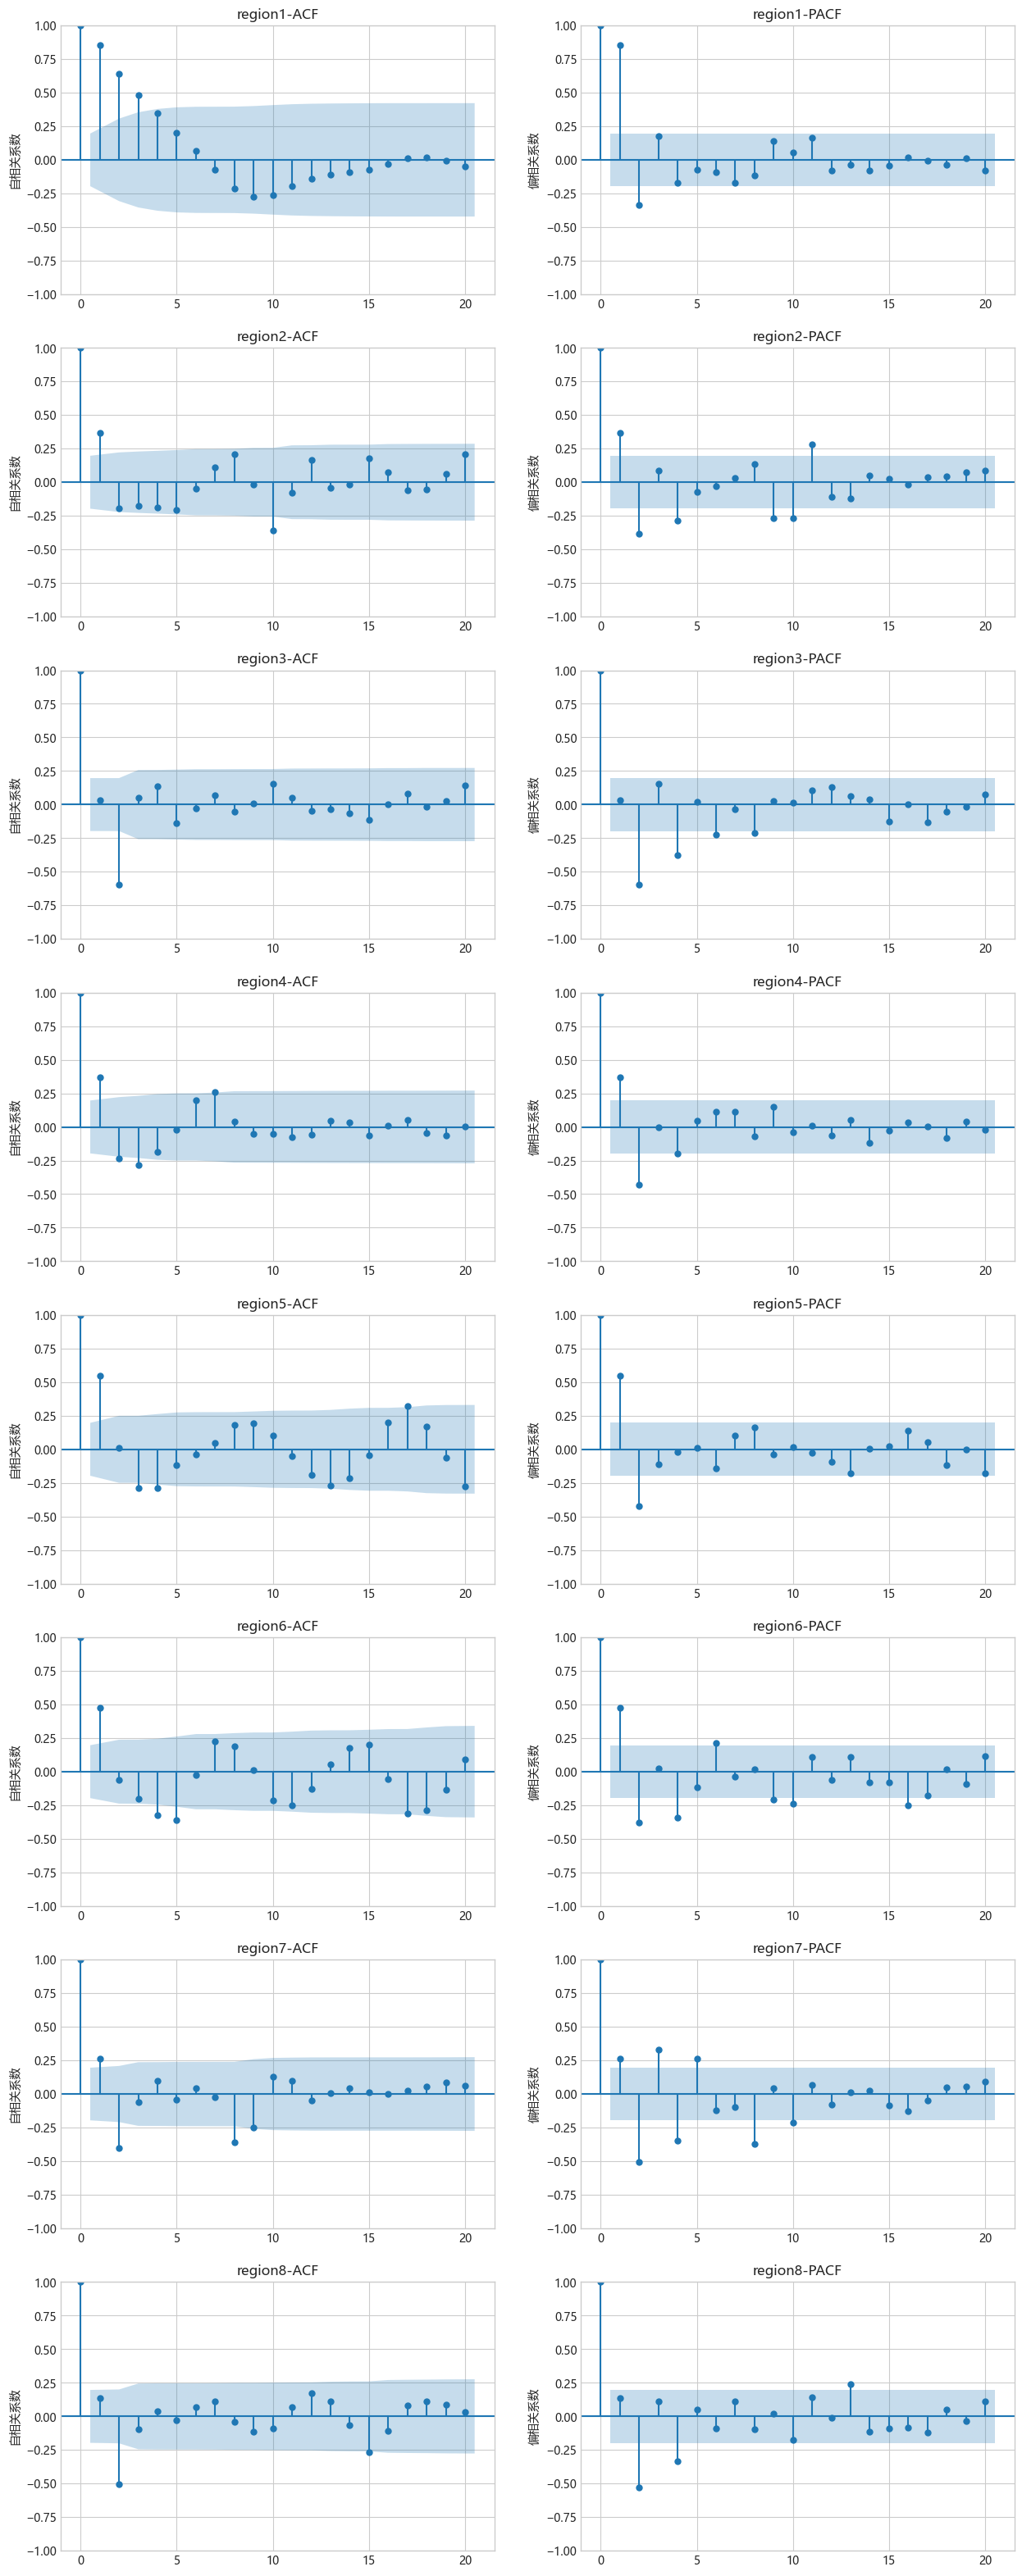

In [11]:
fig, ax = plt.subplots(8, 2, figsize=(15, 40))

for i in range(1, 9):

    # 绘制时间序列的ACF和PACF图
    # 图表每一行代表一个地区
    ts = data.iloc[:, i]
    if diff_[i - 1] == 1:
        ts = ts.diff().dropna()

    plot_acf(ts, ax=ax[i-1, 0])
    plot_pacf(ts, ax=ax[i-1, 1], method='ywm')
    ax[i-1, 0].set_title('region%d-ACF' % i)
    ax[i-1, 1].set_title('region%d-PACF' % i)
    ax[i-1, 0].set_ylabel('自相关系数')
    ax[i-1, 1].set_ylabel('偏相关系数')

# plt.savefig('图片\ACF和PACF图.png')

In [12]:
# ARIMA(Autoregressive Integrated Moving Average model)差分整合移动平均自回归模型
# 模型的参数(p, d, q), 每一个元组对应一个地区的模型参数(参数的设置由ACF、PACF图和ADF检验得来)
# p: 时间序列数据本身的滞后数(属于Autoregressive model自回归模型)
# d: 数据进行差分的次数
# q: 预测误差的滞后数(属于Moving average model滑动平均模型)
param = [(2, 0, 3), (2, 1, 1), (0, 1, 2), (2, 1, 1), (2, 1, 0), (2, 1, 1), (2, 0, 2), (0, 1, 0)]
dw = pd.DataFrame(index=['region%d' % i for i in range(1, 9)], columns=['统计量'])

resid, forecast = [], []

for i in range(1, 9):
    ts = data.iloc[:, i]

    # 进行自动 ARIMA 模型拟合(想看算法拟合的参数可以把下面四行的#去掉)
    # from pmdarima import auto_arima
    # model = auto_arima(ts)
    # order = model.order
    # print(order)

    # 训练 ARIMA 模型
    model = ARIMA(ts, order=param[i - 1])
    result = model.fit()

    # 残差
    resid.append(result.resid)

    # 预测
    forecast.append(result.predict(start=0, end=len(ts)-1, typ='levels'))

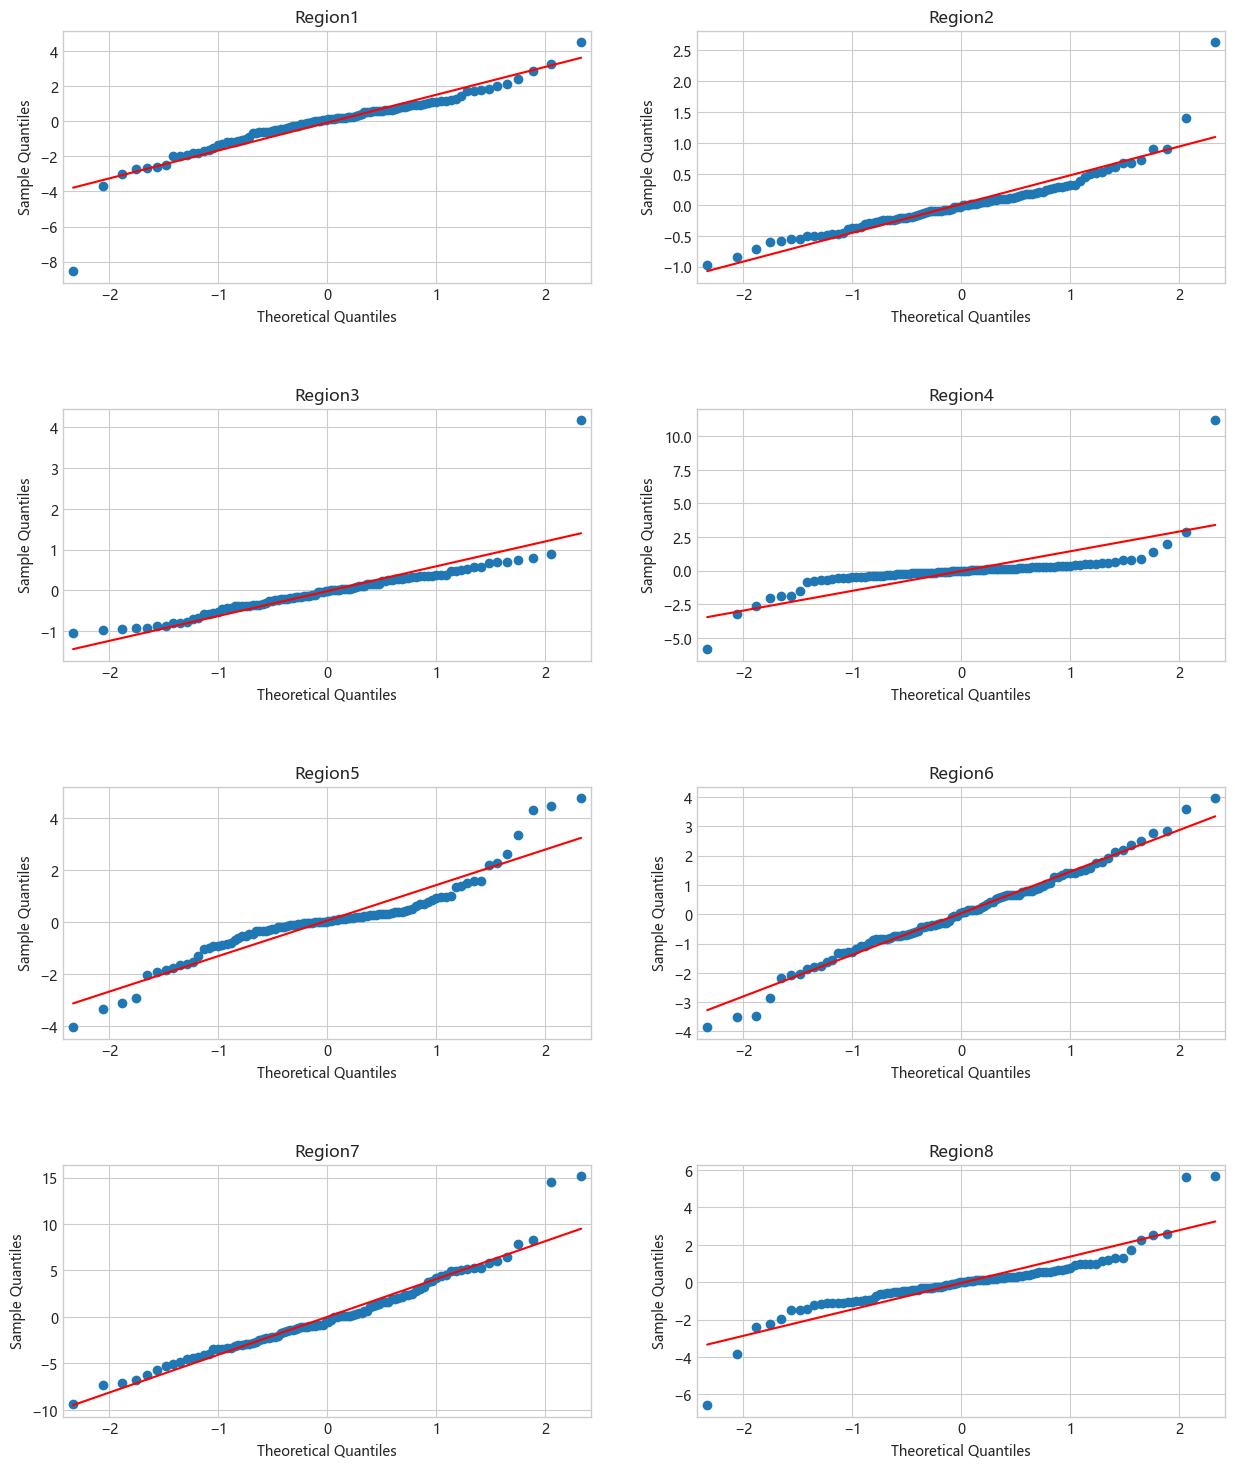

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(15, 18))
for i in range(0, 4):

    # 绘制残差的概率图
    # 数据点大致分布在直线附近，说明残差近似服从正态分布

    sm.qqplot(resid[2*i], ax=ax[i, 0], line='s')
    sm.qqplot(resid[2*i+1], ax=ax[i, 1], line='s')
    ax[i, 0].set_title('Region%d' % (2*i+1))
    ax[i, 1].set_title('Region%d' % (2*i+2))
    fig.subplots_adjust(hspace=0.5)

# plt.savefig('图片\概率图.png')

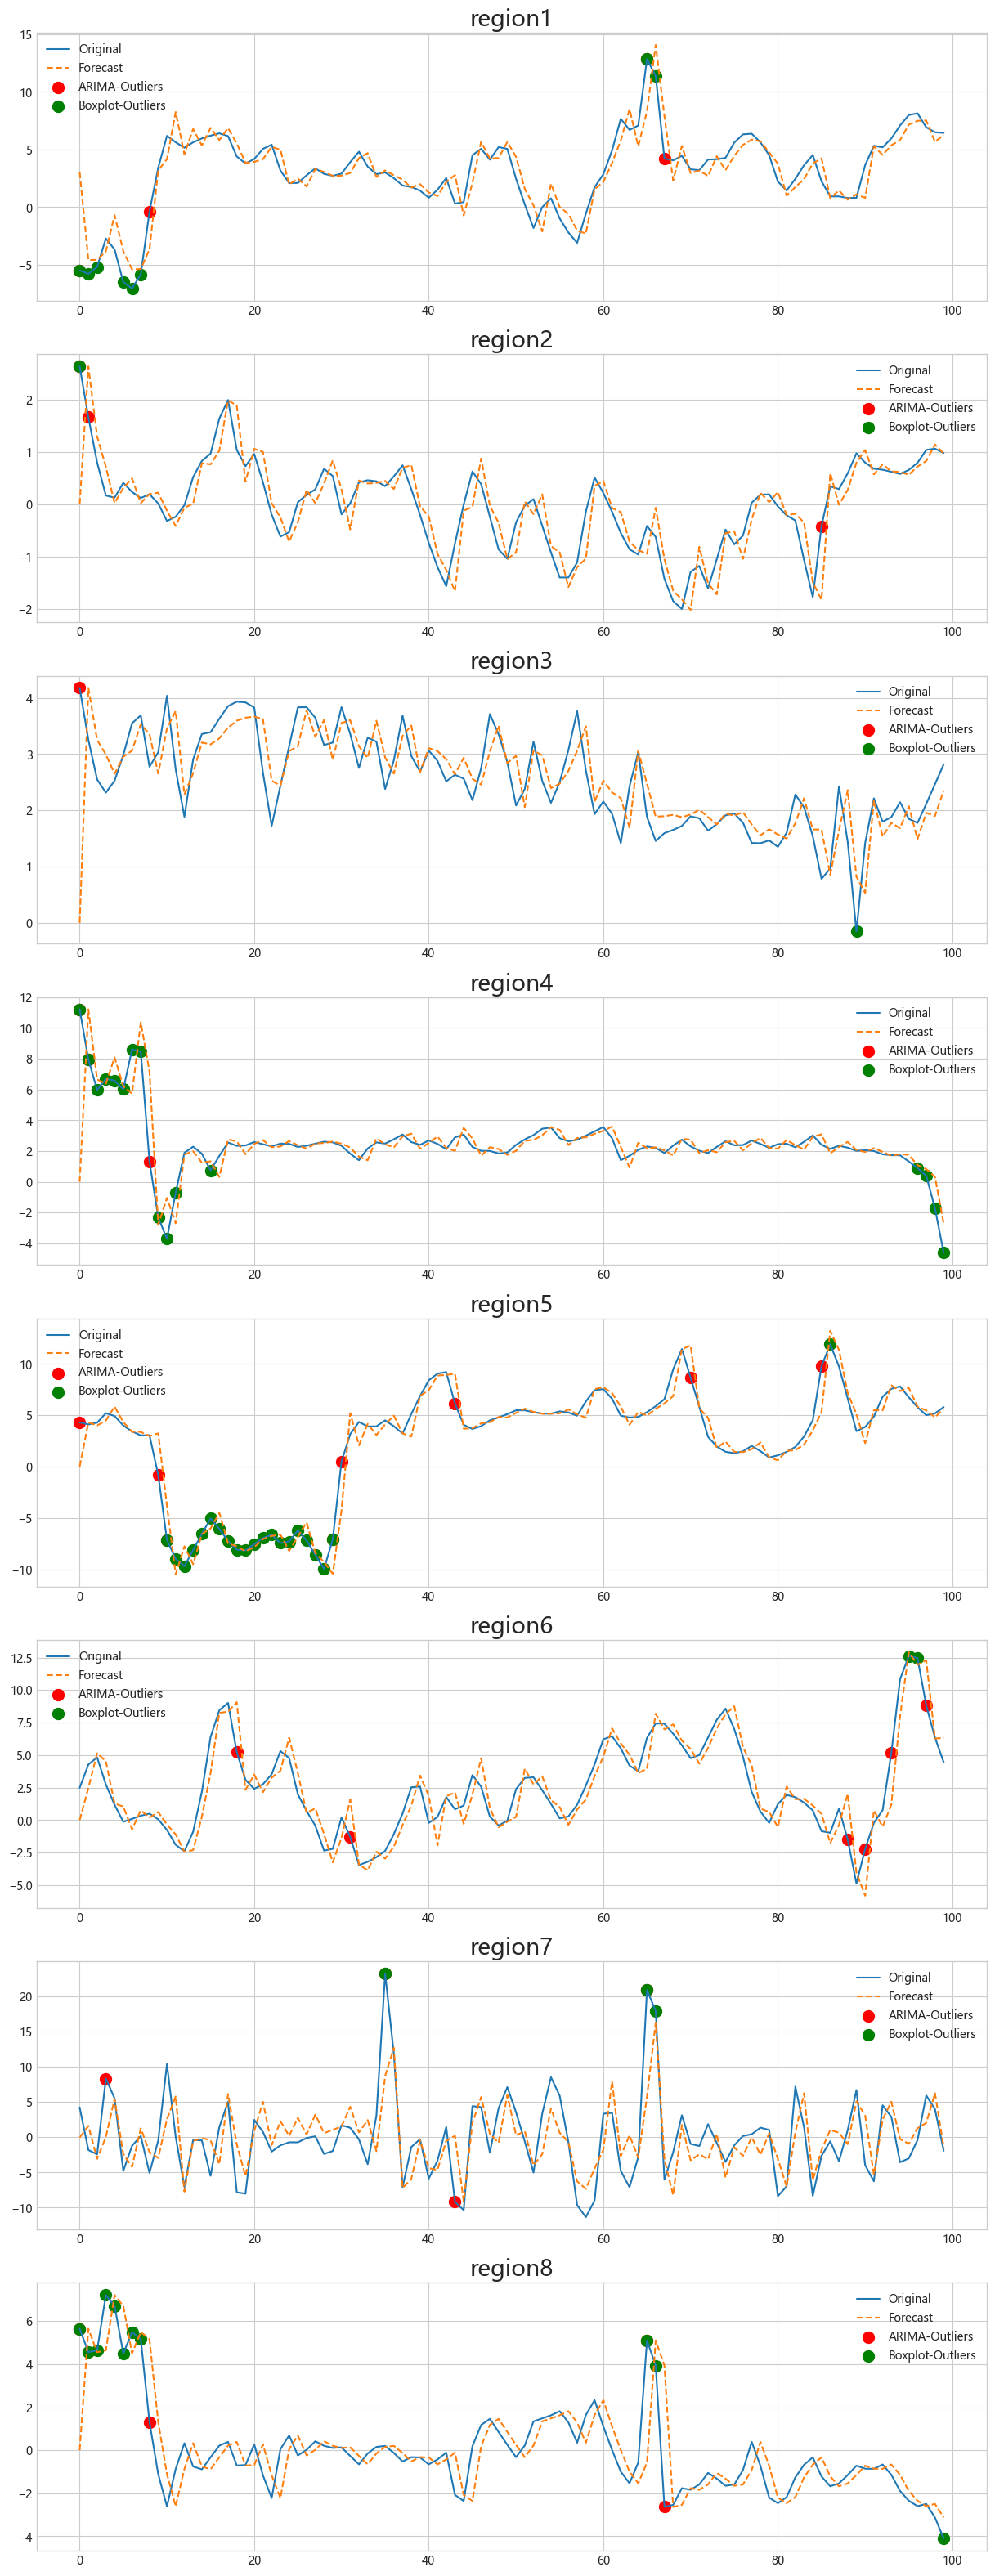

In [14]:
fig, ax = plt.subplots(8, 1, figsize=(15, 40))
for i in range(1, 9):

    ts = data.iloc[:, i]

    ax[i-1].plot(ts, label='Original')
    ax[i-1].plot(forecast[i-1], linestyle='--', label='Forecast')

    # 因残差近似服从正态分布，所以基于2σ准则判断异常点
    resid_std = resid[i-1].std()
    resid_mean = resid[i-1].mean()

    # 不在（μ - 2σ，μ + 2σ）区间内的布尔索引，即异常值的布尔索引
    outliers = (resid_mean + 2 * resid_std < resid[i-1]) | (resid[i-1] < resid_mean - 2 * resid_std)

    # ARIMA模型标注的异常点为红色
    # 箱形图标注的异常点为绿色，有可能把同一个位置的红色点覆盖掉
    ax[i-1].scatter(np.arange(100)[outliers], ts[outliers], c='red', s=100, label='ARIMA-Outliers')

    # 箱形图
    q1, q3 = ts.quantile(q=[0.25, 0.75])
    iqr = q3 - q1
    outliers_index = (ts < (q1 - 1.5 * iqr)) | (ts > (q3 + 1.5 * iqr))
    ax[i-1].scatter(np.arange(100)[outliers_index], ts[outliers_index], c='green', s=100, label='Boxplot-Outliers')
    ax[i-1].set_title('region%d' % i, fontsize=20)
    ax[i-1].legend()

# plt.savefig('图片\模型预测效果图.png')